# Traffic Density Vs Nearby Facilities
    Joseph Antony
    20th June 2023

In [1]:
import warnings
import numpy as np

from datetime import datetime, timedelta

import pandas as pd

import polars as pl
pl.enable_string_cache(True)

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="ticks", palette="muted", color_codes=True)

warnings.filterwarnings("ignore")

plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.weight'] = 'bold'

In [2]:
gh_with_loc_info = (
    pl.read_csv("datasets/15_gh_info/ist_geohash_district_loc_info.csv")
    .select(['GEOHASH', 'loc_type'])
    .with_columns(pl.all().cast(pl.Categorical))
    .rename({'loc_type' : 'LOCATION_TYPE'})
)

gh_with_loc_info.head()

GEOHASH,LOCATION_TYPE
cat,cat
"""sxk3xw""","""avenue"""
"""sxk9nm""","""other"""
"""sxk9q0""","""street"""
"""sxk3hx""","""other"""
"""sx7cmx""","""street"""


### Three more additional datasets will be added. They include:
* Number of nearby Fuel Stations in Istanbul within 1km radius of a GEOHASH
* Number of nearby Public Bicycle stands [(ISBIKE)](https://en.wikipedia.org/wiki/%C4%B0sbike) within 1km radius of a GEOHASH
* Number of nearby bicycle and micromobility parking spaces within 1km radius of a GEOHASH
* Location type of GEOHASH (highway, road, junction etc)

In [3]:
# Data for nearby Fuel stns

nearby_fuel_stn_df = (
    pl.read_csv("datasets/13_gh_proximities/gh_nearby_fuelstns.csv")
    .filter(pl.col('type').eq('geohash'))
    .groupby('name').agg(pl.col('nearest').n_unique())
    .rename({'name' : 'GEOHASH', 'nearest' : 'NEARBY_FUEL_STNS_CNT'})
    .with_columns(pl.col('GEOHASH').cast(pl.Categorical),
                  pl.col('NEARBY_FUEL_STNS_CNT').cast(pl.UInt8))
)

nearby_fuel_stn_df.head()
    

GEOHASH,NEARBY_FUEL_STNS_CNT
cat,u8
"""sxk3xg""",1
"""sxkd1r""",2
"""sxk98d""",3
"""sxkbg7""",1
"""sxk3sb""",1


In [4]:
nearby_isbike_stnds_df = (
    pl.read_csv("datasets/13_gh_proximities/gh_nearby_isbike_stnds.csv")
    .filter(pl.col('type').eq('geohash'))
    .groupby('name').agg(pl.col('nearest').n_unique())
    .rename({'name' : 'GEOHASH', 'nearest' : 'NEARBY_ISBIKE_STANDS_CNT'})
    .with_columns(pl.col('GEOHASH').cast(pl.Categorical),
                  pl.col('NEARBY_ISBIKE_STANDS_CNT').cast(pl.UInt8))
)

nearby_isbike_stnds_df.head()

GEOHASH,NEARBY_ISBIKE_STANDS_CNT
cat,u8
"""sxk9v2""",3
"""sxk9s9""",2
"""sxkb91""",6
"""sxk9s8""",1
"""sxk97s""",1


In [5]:
nearby_bike_mm_parking = (
    pl.read_csv("datasets/13_gh_proximities/gh_nearby_bike_mm_parking.csv")
    .filter(pl.col('type').eq('geohash'))
    .groupby('name').agg(pl.col('nearest').n_unique())
    .rename({'name' : 'GEOHASH', 'nearest' : 'NEARBY_BIKE_MM_PARKING_CNT'})
    .with_columns(pl.col('GEOHASH').cast(pl.Categorical),
                  pl.col('NEARBY_BIKE_MM_PARKING_CNT').cast(pl.UInt8))
)

nearby_bike_mm_parking.head()

GEOHASH,NEARBY_BIKE_MM_PARKING_CNT
cat,u8
"""sxk91x""",1
"""sxk9n7""",2
"""sxk91n""",1
"""sxk35q""",1
"""sxk9md""",1


## Joining with new datasets

In [6]:
all_cols = (
    pl.scan_parquet("datasets/00_tr_df_merged/tr_ist_td_merged_full.zstd")
    .columns
)

nearby_cols = [col for col in all_cols if col.startswith("NEARBY")]
nearby_cols

['NEARBY_LANDMARKS_CNT',
 'NEARBY_PARKING_CAPACITY',
 'NEARBY_TAXI_STND_CNT',
 'NEARBY_MINIBUS_STOPS_CNT',
 'NEARBY_FERRIES_CNT',
 'NEARBY_METRO_STNS_CNT',
 'NEARBY_BUS_STOP_CNT']

In [7]:
%%time

select_Cols = ['DATE_TIME', 'GEOHASH', 'NUMBER_OF_VEHICLES', 'DISTRICT'] + nearby_cols

pl_df = (
    pl.scan_parquet("datasets/00_tr_df_merged/tr_ist_td_merged_full.zstd")
    .select(select_Cols)
    .with_columns(pl.col('DATE_TIME').dt.date().alias('DATE'))

    # location information data
    .join(gh_with_loc_info.lazy(), on='GEOHASH', how='left')

    # Fuel stations
    .join(nearby_fuel_stn_df.lazy(), on='GEOHASH', how='left')

    # ISBIKE stands
    .join(nearby_isbike_stnds_df.lazy(), on='GEOHASH', how='left')

    # ISBIKE stands
    .join(nearby_bike_mm_parking.lazy(), on='GEOHASH', how='left')

    .with_columns(pl.col(['NEARBY_FUEL_STNS_CNT', 'NEARBY_ISBIKE_STANDS_CNT', 'NEARBY_BIKE_MM_PARKING_CNT'])
                 .fill_null(0))
    
).collect(streaming=True)

pl_df.head()

Wall time: 52.8 s


DATE_TIME,GEOHASH,NUMBER_OF_VEHICLES,DISTRICT,NEARBY_LANDMARKS_CNT,NEARBY_PARKING_CAPACITY,NEARBY_TAXI_STND_CNT,NEARBY_MINIBUS_STOPS_CNT,NEARBY_FERRIES_CNT,NEARBY_METRO_STNS_CNT,NEARBY_BUS_STOP_CNT,DATE,LOCATION_TYPE,NEARBY_FUEL_STNS_CNT,NEARBY_ISBIKE_STANDS_CNT,NEARBY_BIKE_MM_PARKING_CNT
datetime[ns],cat,u16,cat,u8,u16,u8,u8,u8,u8,u8,date,cat,u8,u8,u8
2020-01-01 00:00:00,"""sxkbj3""",97,"""Gebze""",0,0,0,0,0,0,1,2020-01-01,"""avenue""",0,0,0
2020-01-01 01:00:00,"""sxkbj3""",58,"""Gebze""",0,0,0,0,0,0,1,2020-01-01,"""avenue""",0,0,0
2020-01-01 02:00:00,"""sxkbj3""",40,"""Gebze""",0,0,0,0,0,0,1,2020-01-01,"""avenue""",0,0,0
2020-01-01 03:00:00,"""sxkbj3""",33,"""Gebze""",0,0,0,0,0,0,1,2020-01-01,"""avenue""",0,0,0
2020-01-01 04:00:00,"""sxkbj3""",25,"""Gebze""",0,0,0,0,0,0,1,2020-01-01,"""avenue""",0,0,0


In [8]:
all_nearby = [col for col in pl_df.columns if col.startswith("NEARBY")]
all_nearby

['NEARBY_LANDMARKS_CNT',
 'NEARBY_PARKING_CAPACITY',
 'NEARBY_TAXI_STND_CNT',
 'NEARBY_MINIBUS_STOPS_CNT',
 'NEARBY_FERRIES_CNT',
 'NEARBY_METRO_STNS_CNT',
 'NEARBY_BUS_STOP_CNT',
 'NEARBY_FUEL_STNS_CNT',
 'NEARBY_ISBIKE_STANDS_CNT',
 'NEARBY_BIKE_MM_PARKING_CNT']

### Plots

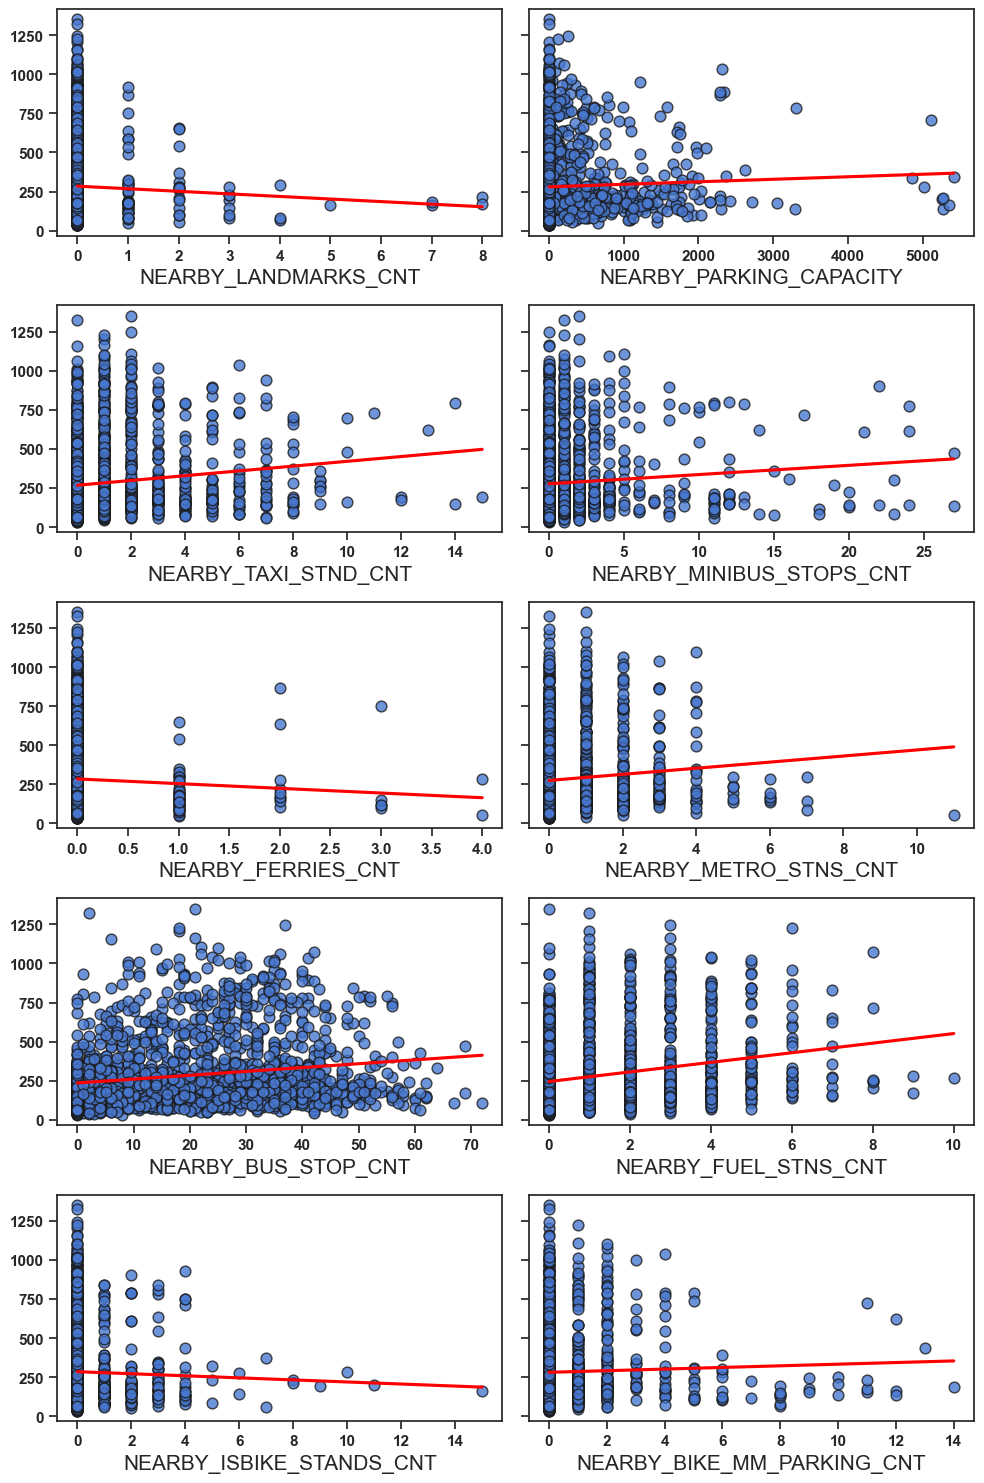

In [9]:
temp_df = (
    pl_df.lazy()
    .groupby('GEOHASH')
    .agg(pl.col(['NUMBER_OF_VEHICLES']).max(),
         pl.col(all_nearby).mean())
    .collect(streaming=True)
    .drop('GEOHASH')
    .to_pandas()
)

fig, axes = plt.subplots(5, 2, figsize=(10, 15), tight_layout=True, sharey=True)

for col, ax in zip(all_nearby, axes.flatten()):

    ax = sns.regplot(
        x=col,
        y='NUMBER_OF_VEHICLES',
        data=temp_df, 
        ci=None,
        line_kws={'color' : 'red'}, 
        scatter_kws={'edgecolor' : 'k', 'alpha' : 0.8, 's':60},
        ax=ax
    )
    ax.set_ylabel("")

    The above scatter plots shows the relation between mean traffic density and mean number of nearby facilities like landmarks, bus stations, metro stations, parking spaces, etc. There is no clear linear relation between traffic density and nearby facilities. 

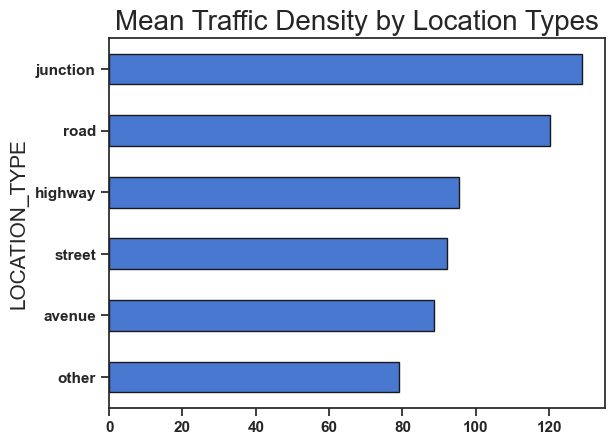

In [10]:
(
    pl_df.groupby('LOCATION_TYPE')
    .agg(pl.col('NUMBER_OF_VEHICLES').mean())
    .sort('NUMBER_OF_VEHICLES')
    .to_pandas()
    .set_index('LOCATION_TYPE')
    .plot(kind='barh', legend=False, edgecolor='k', title="Mean Traffic Density by Location Types")
);

    The above barplot shows mean traffic density by type od location. Junctions, followed by roads have a higher traffic density compared to all other type of location types.

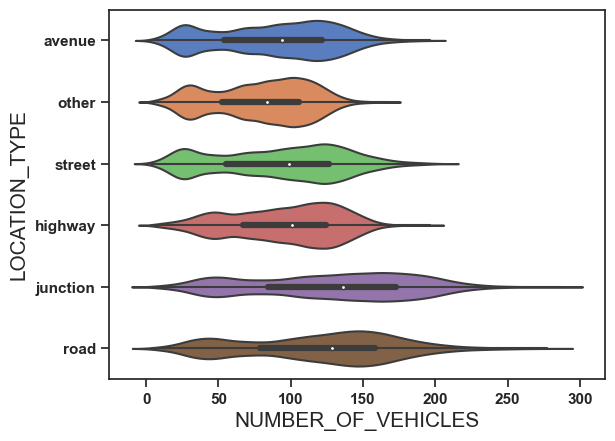

In [11]:
temp_df = (
    pl_df.lazy()
    .groupby(['DATE_TIME', 'LOCATION_TYPE'])
    .agg(pl.col('NUMBER_OF_VEHICLES').mean())
    .collect(streaming=True)
    .to_pandas()
)

sns.violinplot(
    x='NUMBER_OF_VEHICLES',
    y='LOCATION_TYPE',
    data=temp_df,
    orient='h'
);

In [12]:
gh_loc_stats = (
    pl_df.lazy()
    .groupby(['GEOHASH', 'LOCATION_TYPE'])
    .agg(pl.col('NUMBER_OF_VEHICLES').mean(), pl.col(all_nearby).max())
    .collect(streaming=True)
    .to_pandas()
)

gh_loc_stats.head()

,GEOHASH,LOCATION_TYPE,NUMBER_OF_VEHICLES,NEARBY_LANDMARKS_CNT,NEARBY_PARKING_CAPACITY,NEARBY_TAXI_STND_CNT,NEARBY_MINIBUS_STOPS_CNT,NEARBY_FERRIES_CNT,NEARBY_METRO_STNS_CNT,NEARBY_BUS_STOP_CNT,NEARBY_FUEL_STNS_CNT,NEARBY_ISBIKE_STANDS_CNT,NEARBY_BIKE_MM_PARKING_CNT
0,sxk9g9,street,64.437192,0,2288,2,2,0,0,35,3,0,0
1,sxk99c,highway,88.697540,0,905,0,6,0,3,50,7,0,1
2,sxkc0k,other,148.525082,0,0,0,0,0,0,18,2,0,0
3,sxk1sf,other,14.501919,0,0,0,0,0,0,3,0,0,0
4,sxk993,other,195.973170,0,100,1,0,0,1,14,2,0,0


In [13]:
def plot_by_loc(col):

    fig, axes = plt.subplots(3, 2, figsize=(10, 10), tight_layout=True, sharey=True)

    for loc, ax in zip(gh_loc_stats['LOCATION_TYPE'].unique(), axes.flatten()):

        ax = sns.regplot(
            x=col,
            y='NUMBER_OF_VEHICLES',
            data=gh_loc_stats.query(f"LOCATION_TYPE=='{loc}'"),
            ci=None,
            line_kws={'color' : 'red'}, 
            scatter_kws={'edgecolor' : 'k', 'alpha' : 0.8, 's':60},
            ax=ax
        )

        frmt_col = col.replace('_', ' ').title()

        ax.set_ylabel("Mean Traffic Density")
        ax.set_xlabel(f"Mean {frmt_col}")
        ax.set_title(loc)
        
        plt.suptitle(f"Mean Traffic Density vs {frmt_col}", fontsize=20)

    plt.show();

### All of the plots here shows how traffic density related with count of a near by facility by location area.

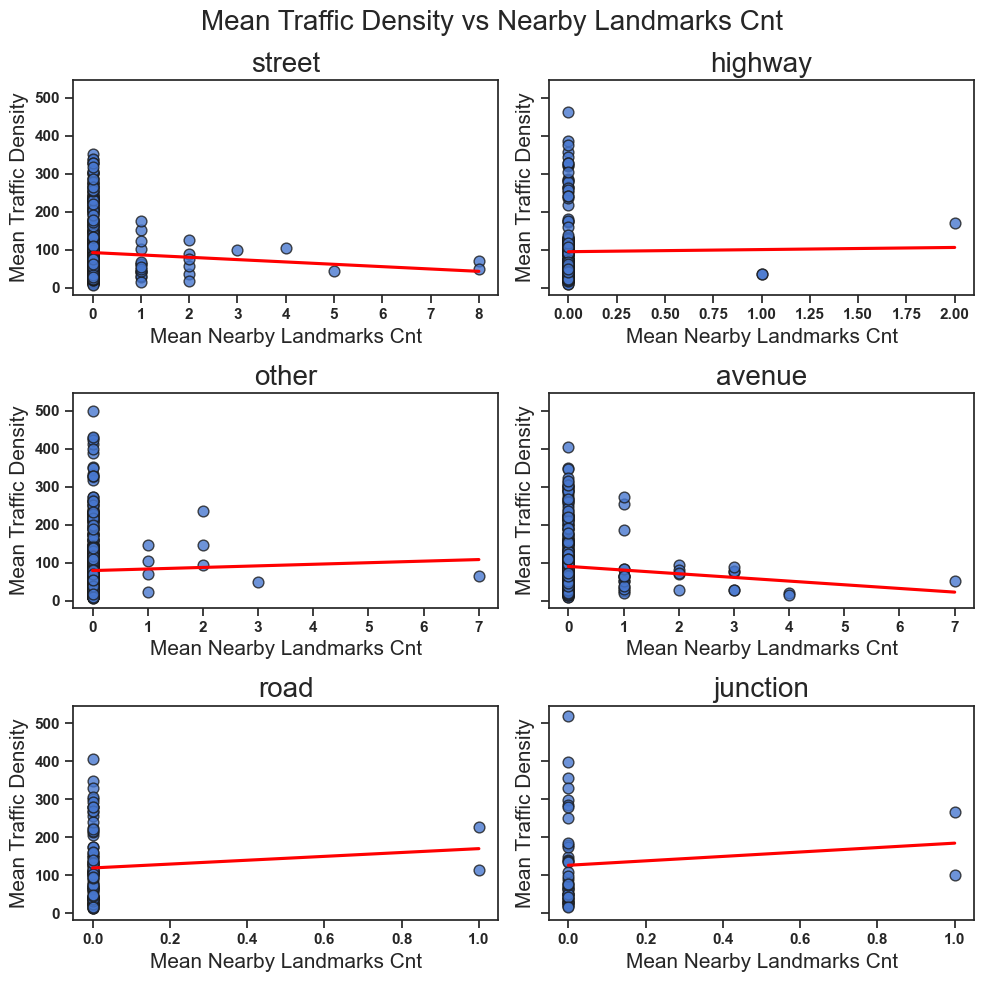

In [14]:
plot_by_loc('NEARBY_LANDMARKS_CNT')

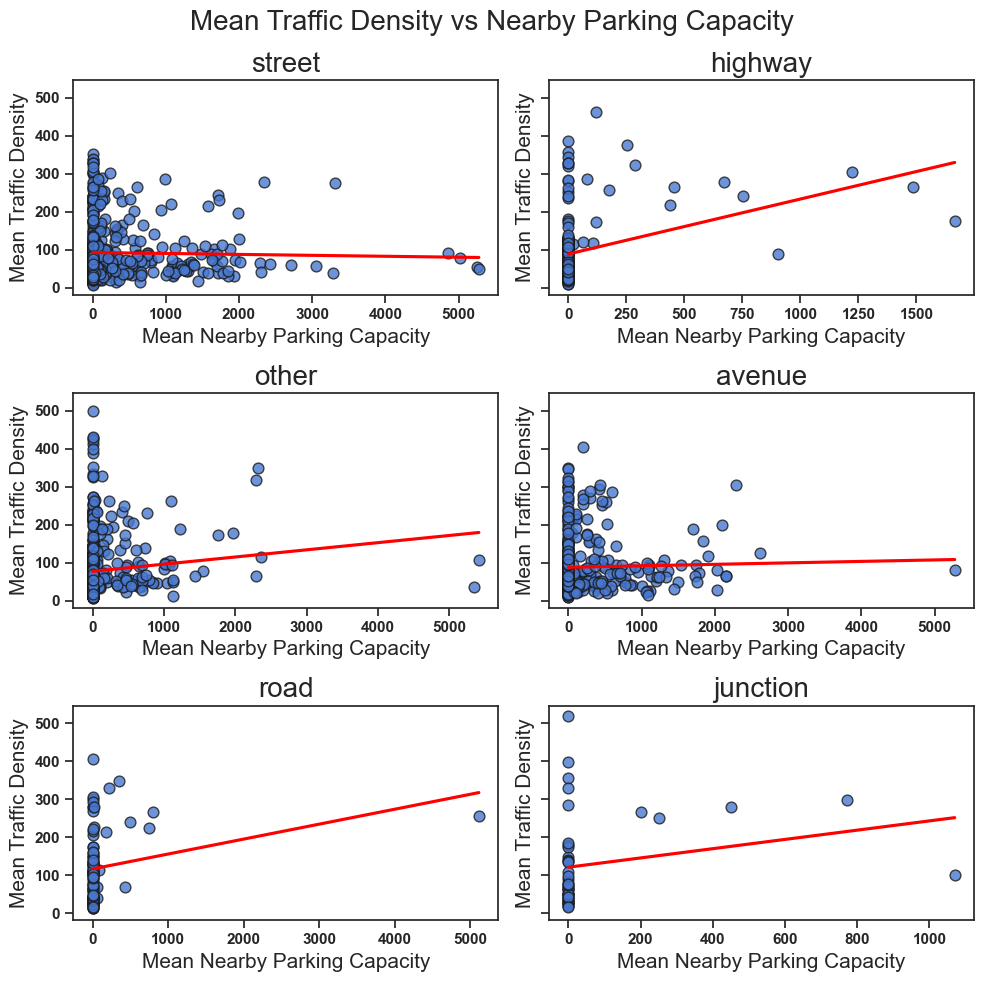

In [15]:
plot_by_loc('NEARBY_PARKING_CAPACITY')

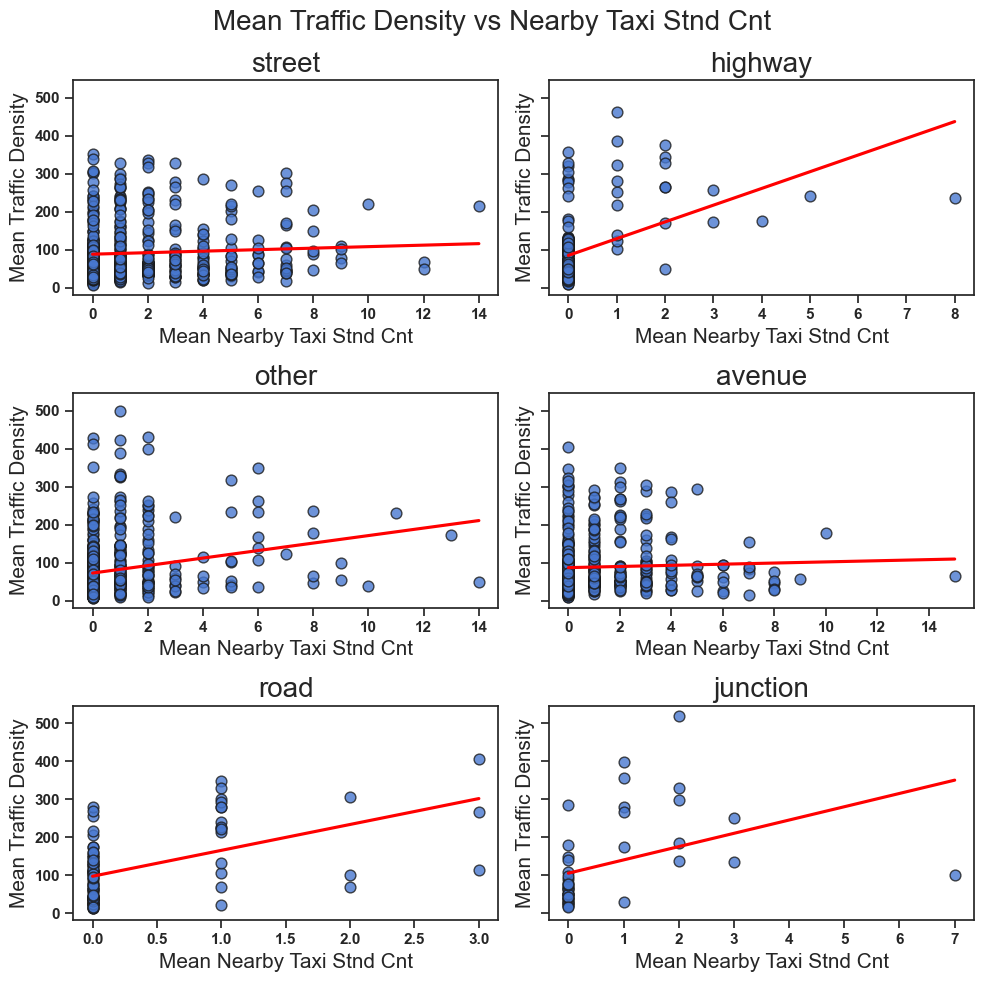

In [16]:
plot_by_loc('NEARBY_TAXI_STND_CNT')

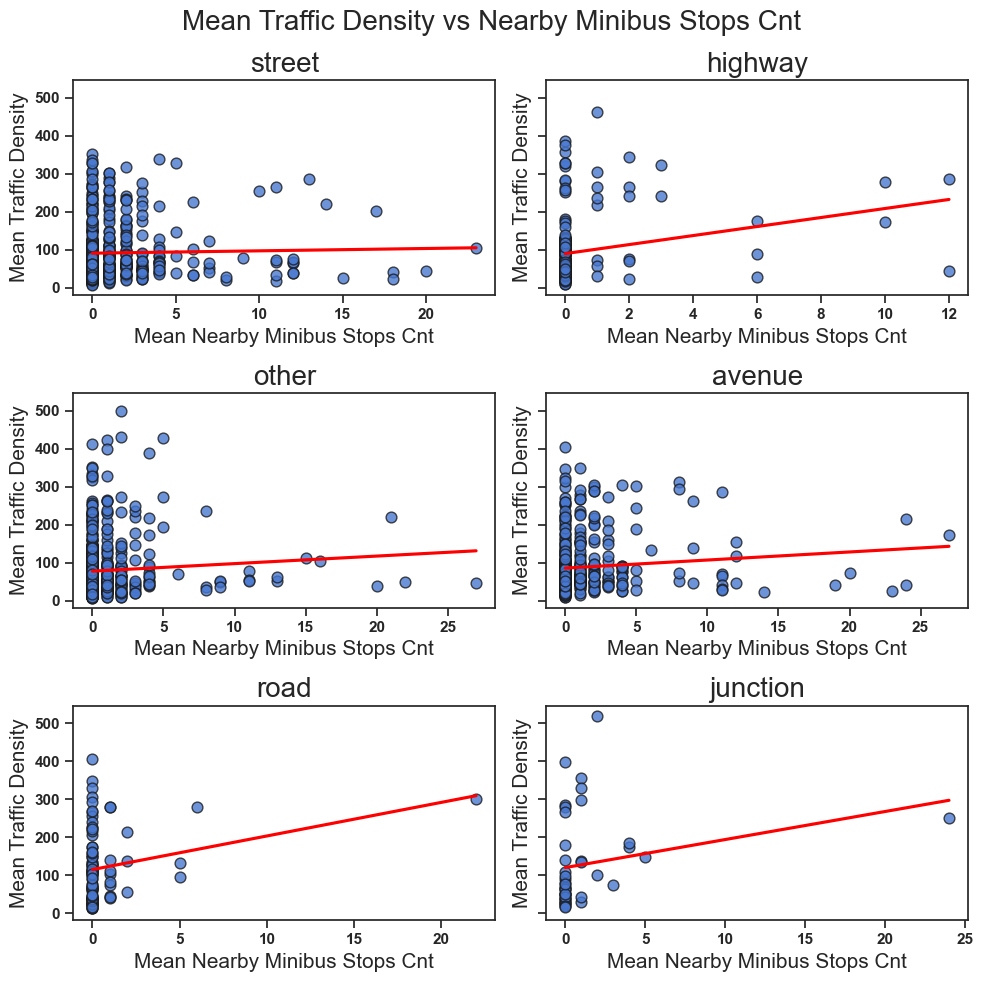

In [17]:
plot_by_loc('NEARBY_MINIBUS_STOPS_CNT')

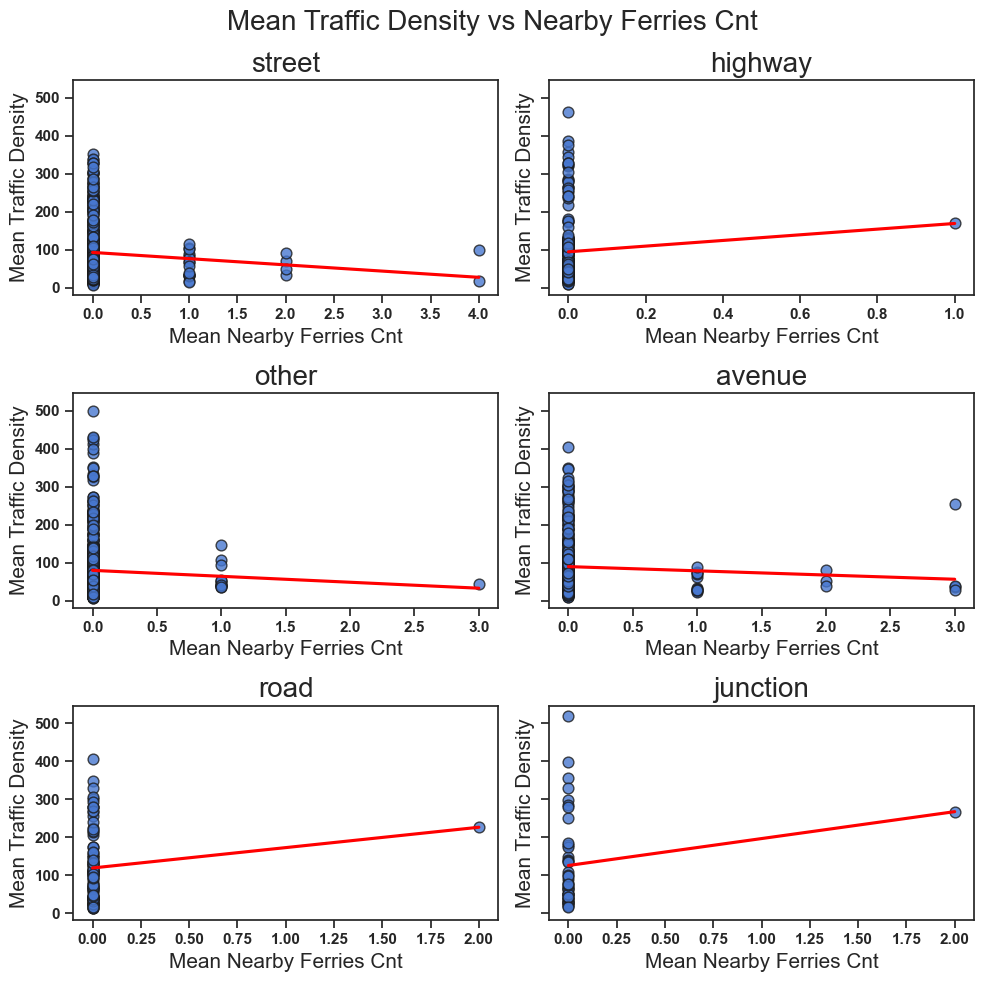

In [18]:
plot_by_loc('NEARBY_FERRIES_CNT')

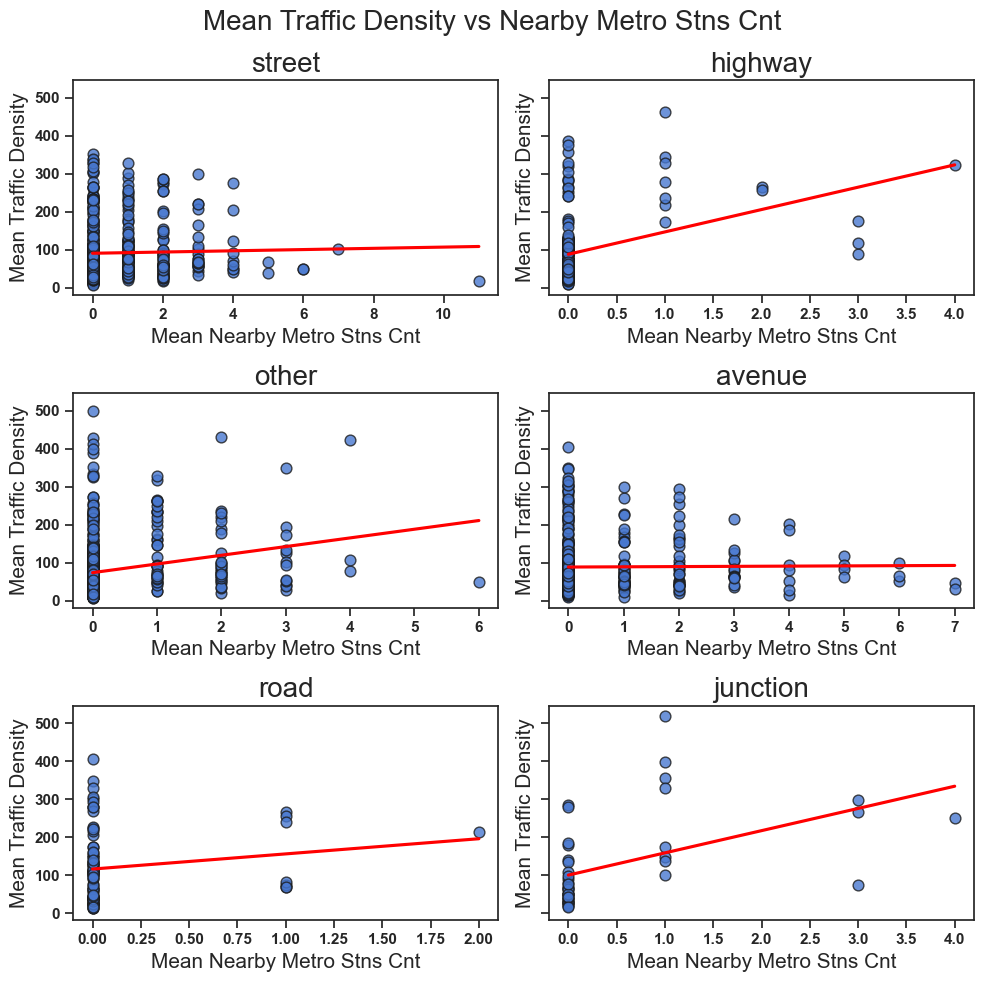

In [19]:
plot_by_loc('NEARBY_METRO_STNS_CNT')

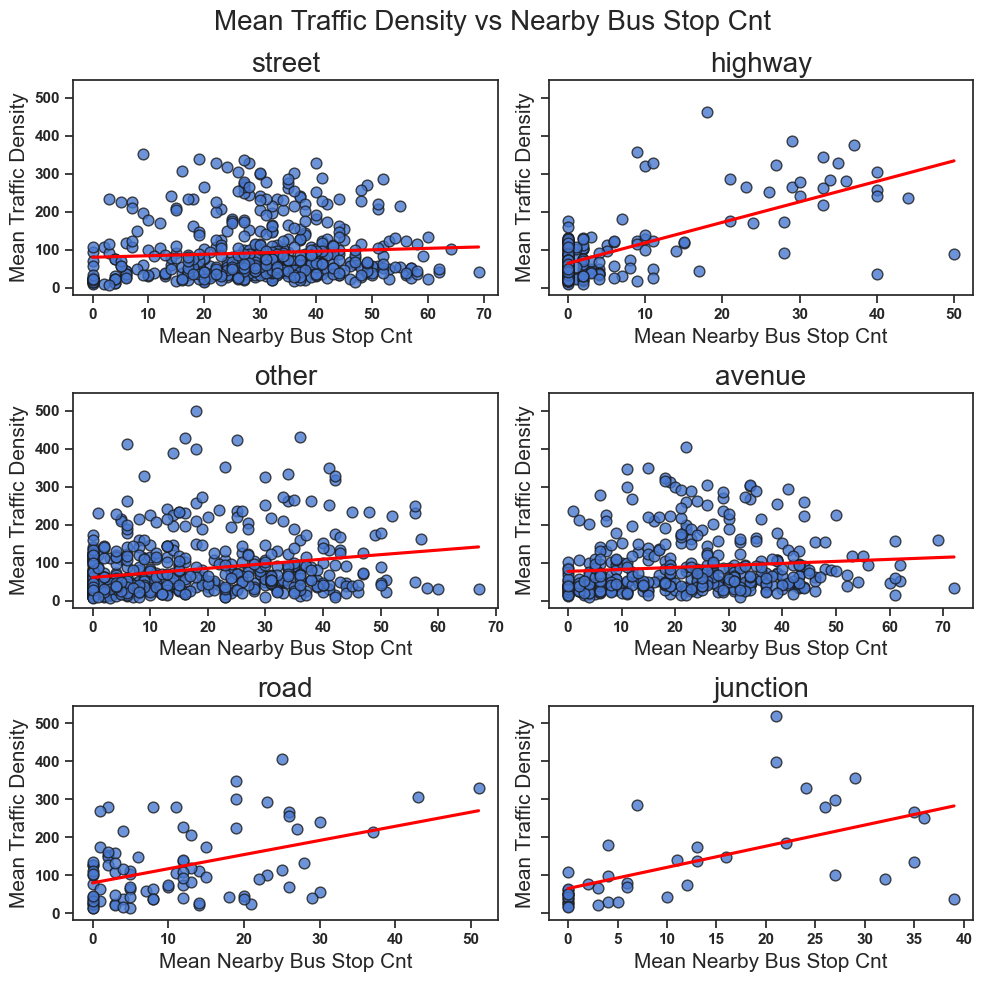

In [20]:
plot_by_loc('NEARBY_BUS_STOP_CNT')

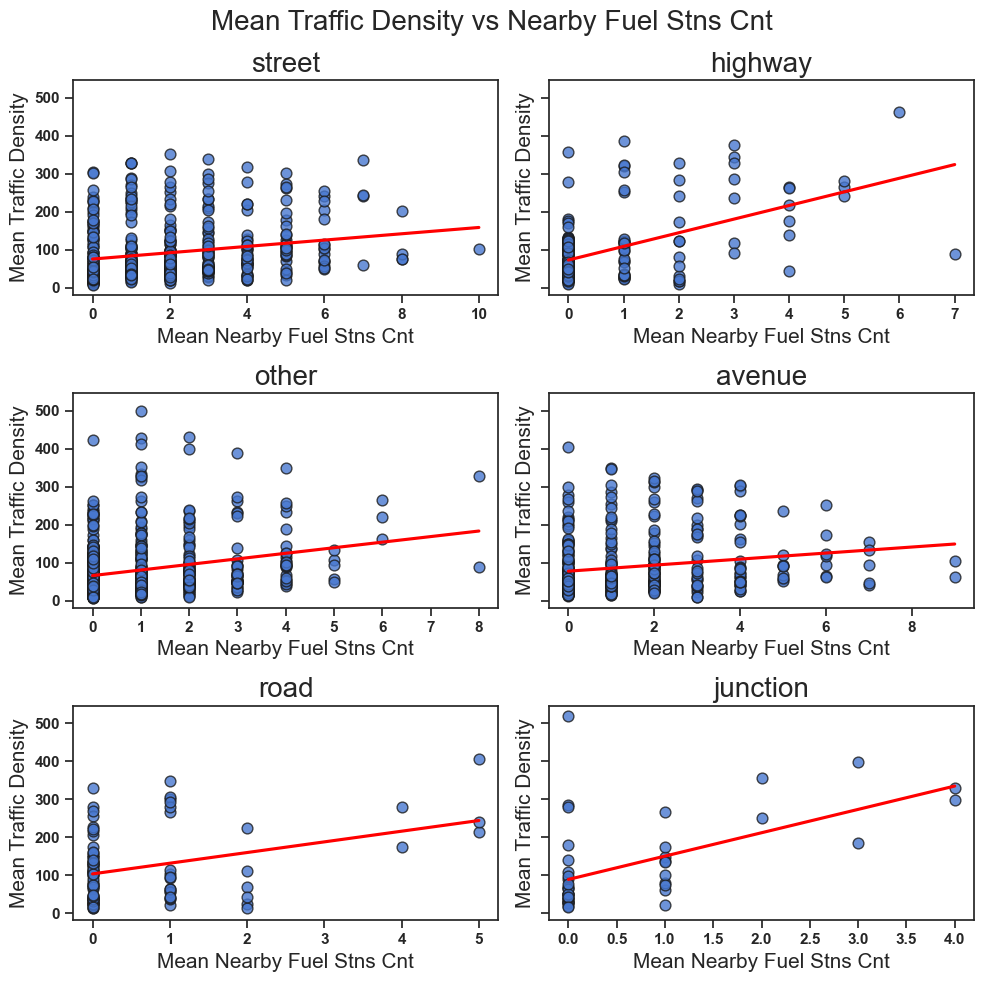

In [21]:
plot_by_loc('NEARBY_FUEL_STNS_CNT')

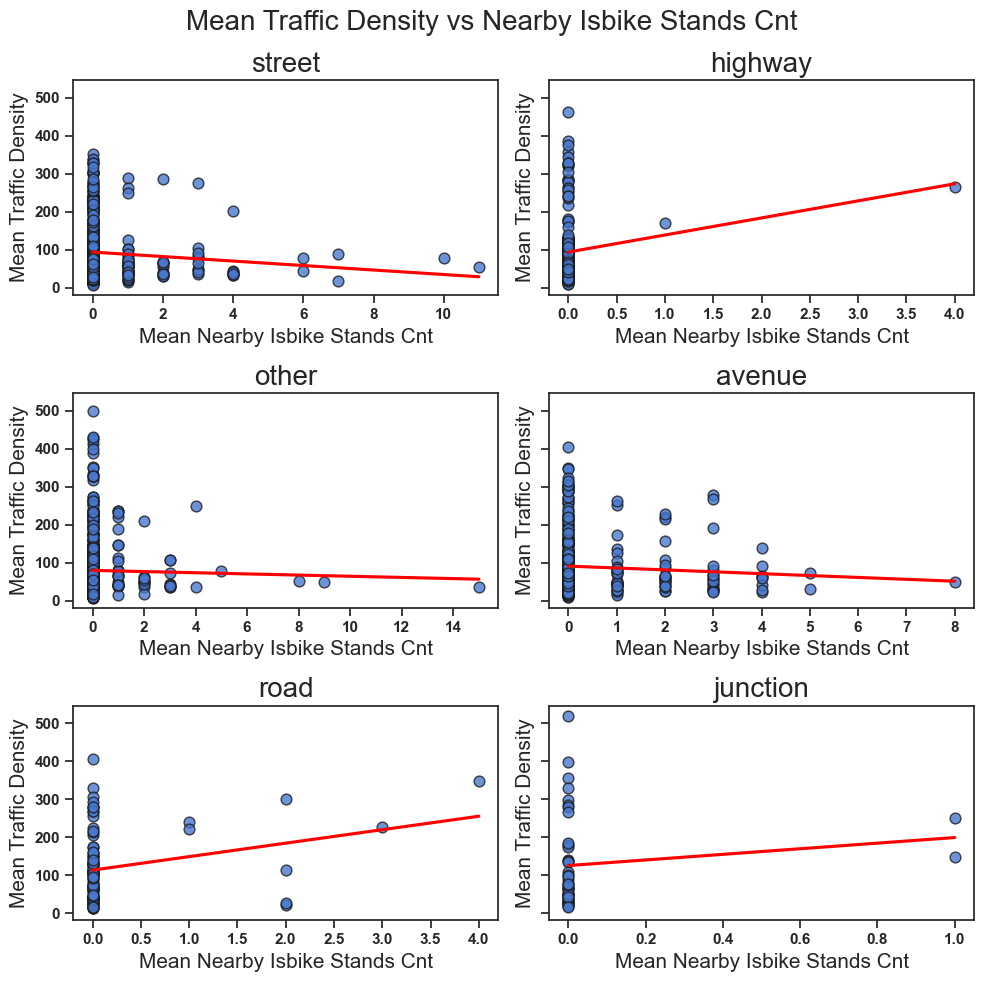

In [22]:
plot_by_loc('NEARBY_ISBIKE_STANDS_CNT')

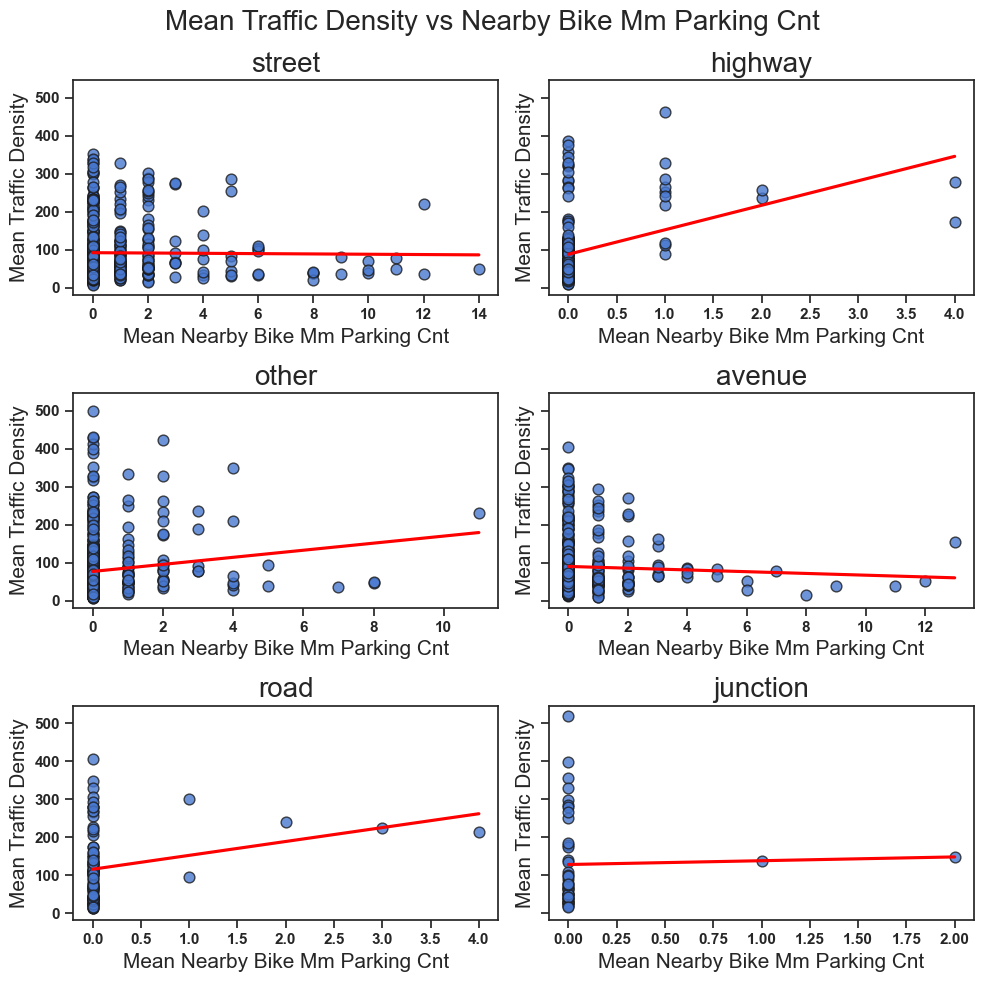

In [23]:
plot_by_loc('NEARBY_BIKE_MM_PARKING_CNT')

### From all of the above plots, it is agaon not very apparant how all of these facilities affect a particular location and how it contributes (or helps relieves) trafficn congestion.

### **The presence of bus stops, metro stations, etc alone may not have a significant impact on traffic density in all areas. Other factors, such as road infrastructure, population density, time of day, and surrounding land use, can also play a crucial role in determining traffic patterns.**

### **It's possible that certain GEOHASH regions show a clear relationship between bus stops and traffic density, while others do not.**

In [24]:
district_facility_TD = (
    pl_df.groupby('DISTRICT')
    .agg(pl.col(all_nearby).max(), pl.col('NUMBER_OF_VEHICLES').max())
    .with_columns(pl.sum(pl.col(all_nearby)).alias('MAX_FACILITIES'))
    .select(['DISTRICT', 'MAX_FACILITIES', 'NUMBER_OF_VEHICLES'])
    .sort('MAX_FACILITIES', descending=True)
)

district_facility_TD

DISTRICT,MAX_FACILITIES,NUMBER_OF_VEHICLES
cat,u16,u16
"""Fatih""",5511,753
"""Maltepe""",5453,1041
"""Eyüpsultan""",5368,931
"""Güngören""",3376,781
"""Kâğıthane""",3140,951
"""Esenler""",2780,669
"""Zeytinburnu""",2700,777
"""Ataşehir""",2515,1062
"""Kadıköy""",2457,888


### The above table shows the max facilities available (by taking max of all nearby facility columns and suming them up) by district. 

### **Fatih, Maltepe and Eyüpsultan has the highest max facilities compared to other GEOHASH.**

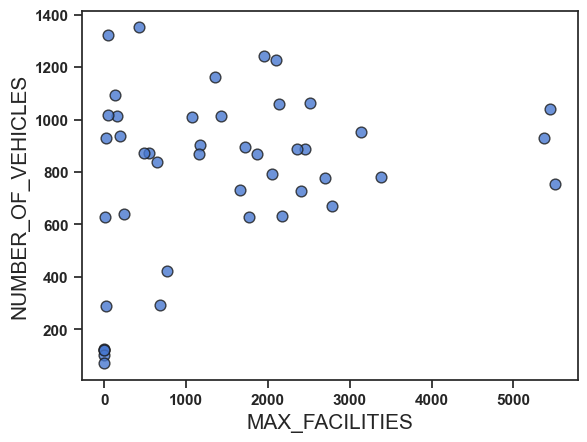

In [25]:
(
    district_facility_TD
    .to_pandas()
    .plot(x='MAX_FACILITIES', y='NUMBER_OF_VEHICLES', kind='scatter', s=60, 
          edgecolor='k', alpha=0.8, color='b')
);

### Again, there is no clear linear relation between the number of facilities a district has vs max traffic density by district.